In [1]:
import torch
from matplotlib import pyplot as plt

from survae import SurVAE
from survae.calibrate import calc_cs, plot_histogram, plot_cdf
from survae.data import ngon, circles, corners, checkerboard, get_spatial_mnist
from survae.layer import BijectiveLayer, AbsoluteUnit, OrthonormalLayer, MaxTheLayer, SortingLayer

# Training Shenanigans

In [2]:
model_generators = [
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
    ),
    lambda: SurVAE(
        [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2])),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
    ),
    lambda: SurVAE(
        [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2]), learn_q=True),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(10)
        ],
    )
]

dataset_functions = [ngon, circles, corners, checkerboard]

In [3]:
# Train the datasets
models = {}
batch_size = 1_000
test_size = 10_000
epochs = 100
log_count = epochs // 10

# Iterate over datasets and create heatmaps
for i, dataset_function in enumerate(dataset_functions):
    for j, model_generator in enumerate(model_generators):
        model = model_generator()
        print(f"[{i * len(model_generators) + j + 1}/{len(dataset_functions) * len(model_generators)}] ", end="")
        results = model.train(
            dataset_function, batch_size=batch_size, test_size=test_size,
            epochs=epochs, lr=0.001, log_count=log_count
        )

        models[i, j] = (model, results)

[1/12] Starting training... done in 5.12 seconds
[2/12] Starting training... done in 4.68 seconds
[3/12] Starting training... done in 4.30 seconds
[4/12] Starting training... done in 5.32 seconds
[5/12] Starting training... done in 5.43 seconds
[6/12] Starting training... done in 4.60 seconds
[7/12] Starting training... done in 3.79 seconds
[8/12] Starting training... done in 4.77 seconds
[9/12] Starting training... done in 4.41 seconds
[10/12] Starting training... done in 5.06 seconds
[11/12] Starting training... done in 5.69 seconds
[12/12] Starting training... done in 5.71 seconds


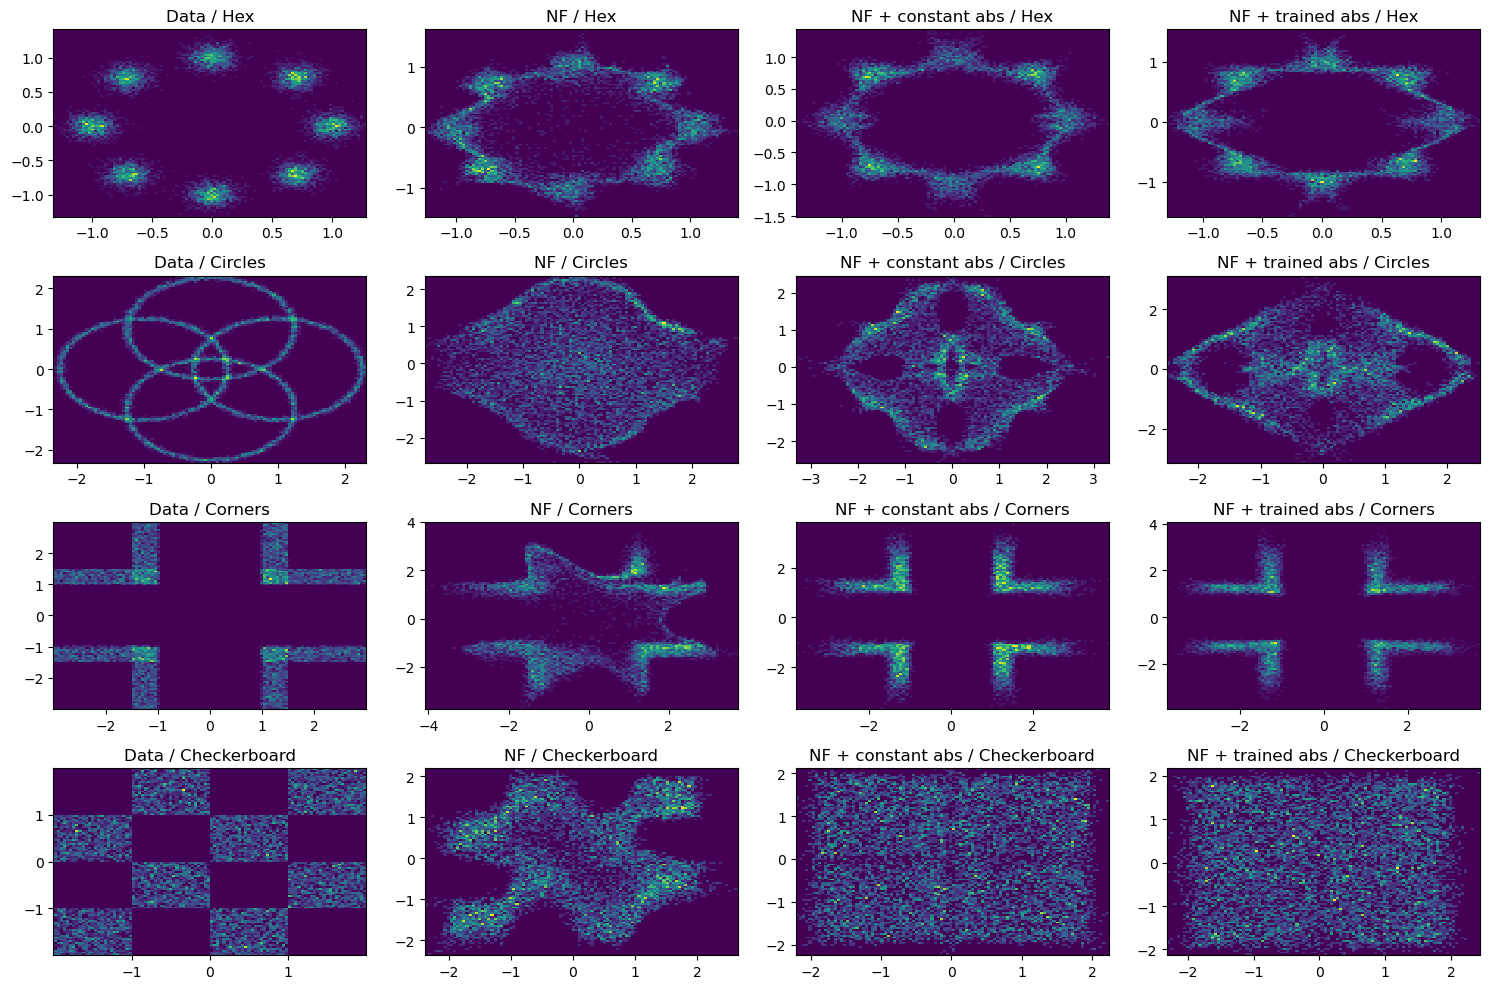

In [4]:
# Define dataset names
model_names = ['NF', 'NF + constant abs', 'NF + trained abs']
dataset_names = ['Hex', 'Circles', 'Corners', 'Checkerboard']

sample_count = 10_000
bins = 100

# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(dataset_names), len(model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(dataset_names, dataset_functions)):
    X = dataset_function(sample_count).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=bins)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        model = models[i, j][0]  # [0] is the model, [1] is parameters/losses for log epochs
        X = model.sample(sample_count).cpu().numpy()

        axs[i, j + 1].hist2d(X[:, 0], X[:, 1], bins=bins)
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')

# Adjust layout
plt.tight_layout()
plt.show()

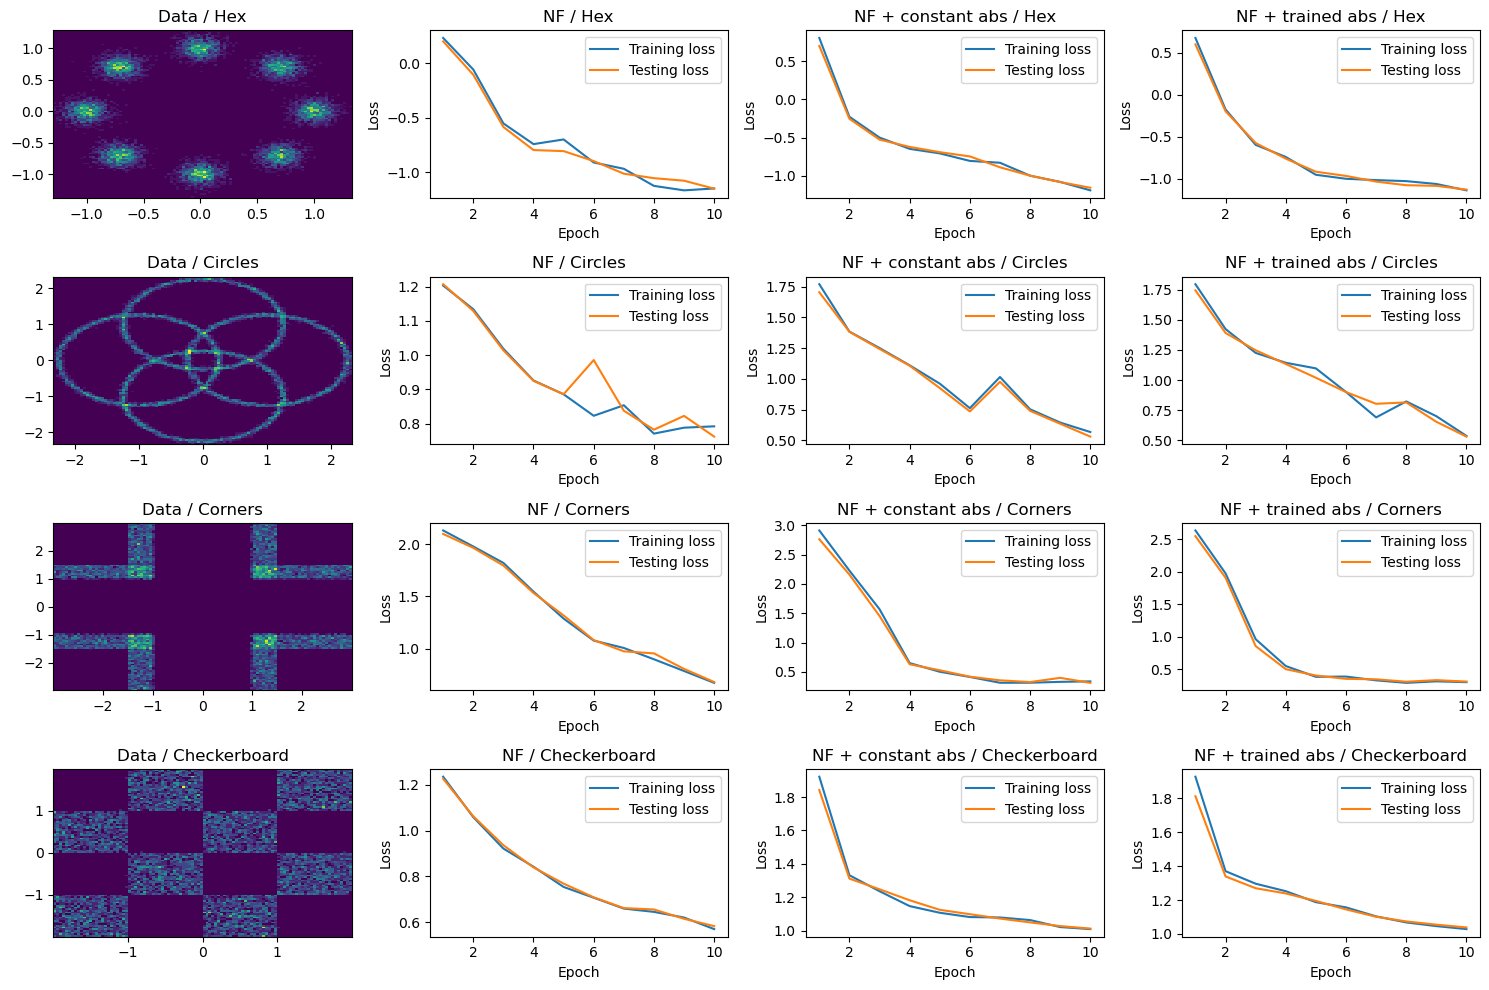

In [5]:
# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(len(dataset_names), len(model_names) + 1, figsize=(15, 10))

# Plot the raw data
for i, (dataset_name, dataset_function) in enumerate(zip(dataset_names, dataset_functions)):
    X = dataset_function(sample_count).cpu().numpy()

    axs[i, 0].hist2d(X[:, 0], X[:, 1], bins=bins)
    axs[i, 0].set_title(f'Data / {dataset_name}')

# Iterate over datasets and create heatmaps for losses
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        training_loss = [l for _, l, _ in models[i, j][1].values()]
        testing_loss = [l for _, _, l in models[i, j][1].values()]
        epochs = list(models[i][1].keys())

        axs[i, j + 1].plot(epochs, training_loss, label='Training loss')
        axs[i, j + 1].plot(epochs, testing_loss, label='Testing loss')
        axs[i, j + 1].set_title(f'{model_name} / {dataset_name}')
        axs[i, j + 1].set_xlabel('Epoch')
        axs[i, j + 1].set_ylabel('Loss')
        axs[i, j + 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

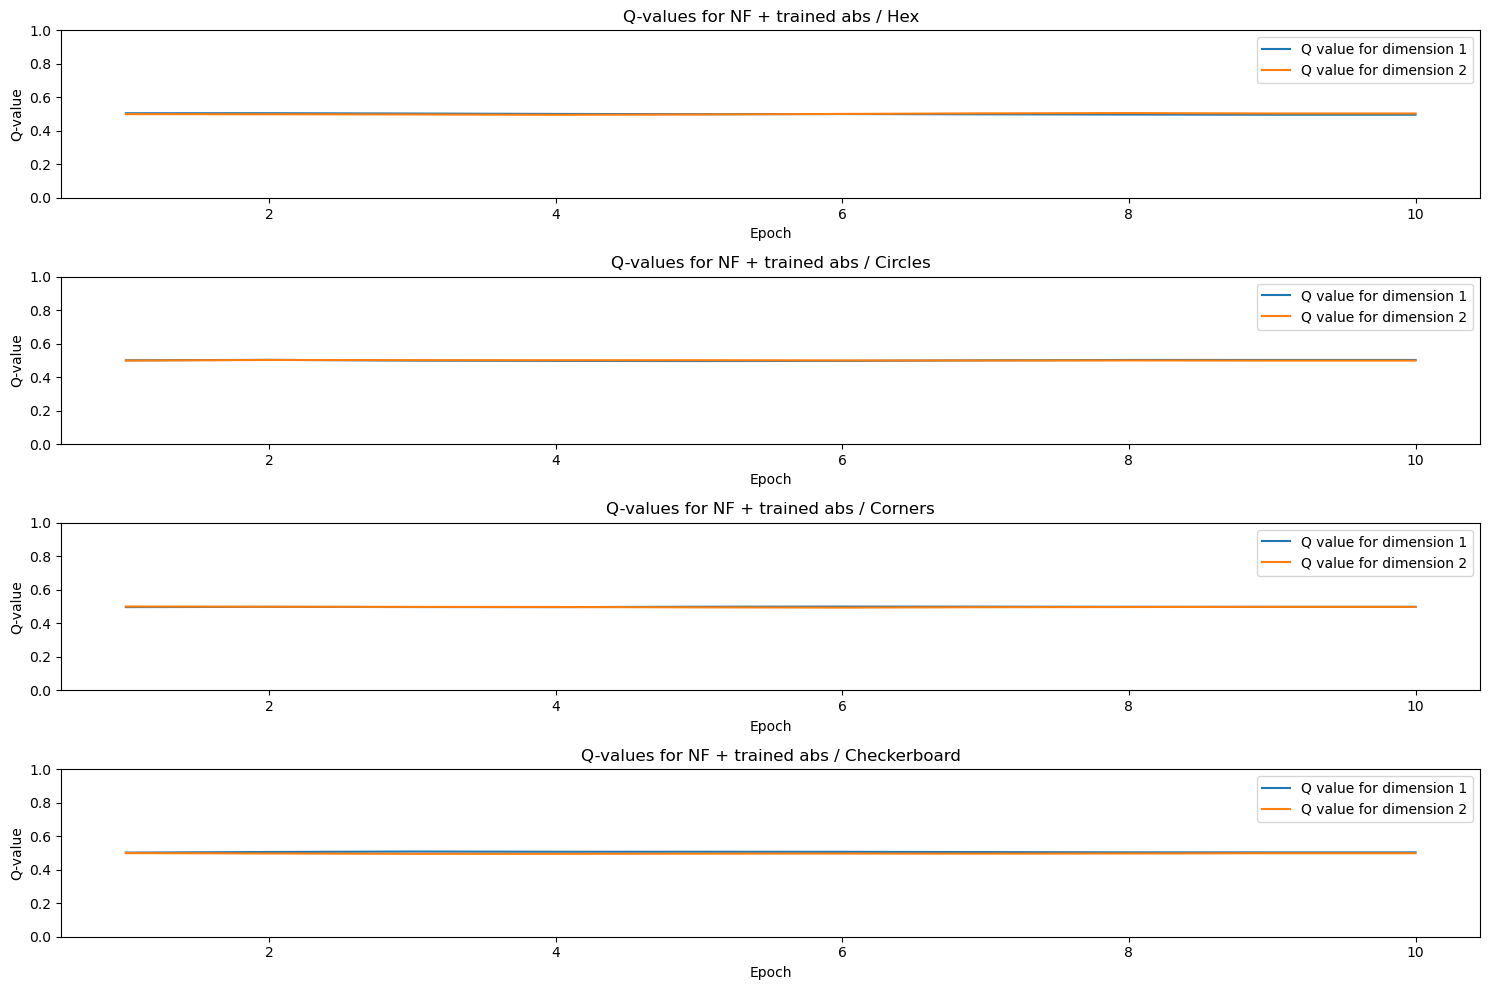

In [6]:
fig, axs = plt.subplots(len(dataset_names), 1, figsize=(15, 10))

for i, dataset_name in enumerate(dataset_names):
    # We're interested in the last model - that is the one that changes the q
    model, states = models[i, len(model_names) - 1]

    q1 = []
    q2 = []
    for epoch, (state_dict, _, _) in states.items():
        model.load_state_dict(state_dict)
        q1.append(model.layers[0].q[0].item())
        q2.append(model.layers[0].q[1].item())

    axs[i].plot(epochs, q1, label="Q value for dimension 1")
    axs[i].plot(epochs, q2, label="Q value for dimension 2")
    axs[i].set_title(f'Q-values for {model_names[-1]} / {dataset_name}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Q-value')
    axs[i].set_ylim([0, 1])
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Calibration

In [9]:
model = models[len(dataset_names) - 1, len(model_names) - 1][0]

In [10]:
X_test = model.sample(100)
cs = calc_cs(model, X_test, 50)

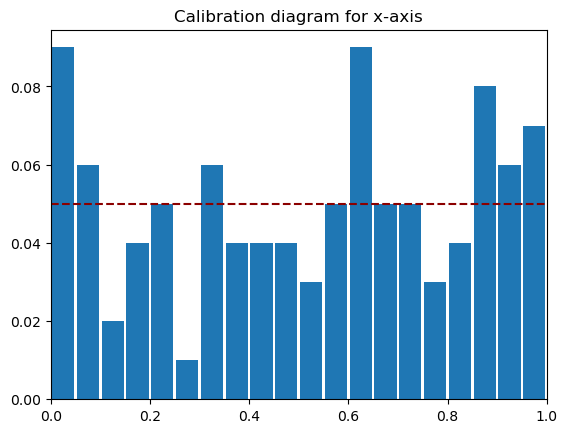

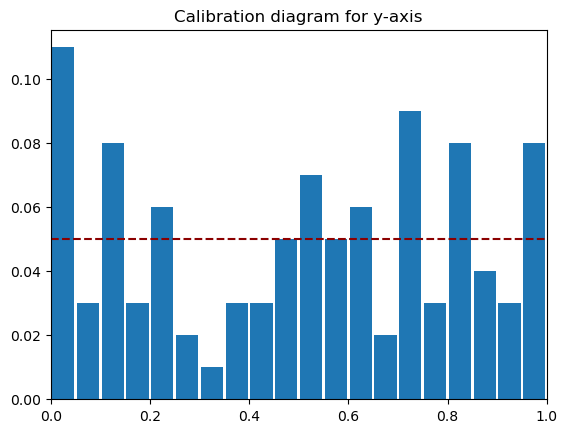

In [11]:
plot_histogram(cs[0], 20, "Calibration diagram for x-axis")
plot_histogram(cs[1], 20, "Calibration diagram for y-axis")

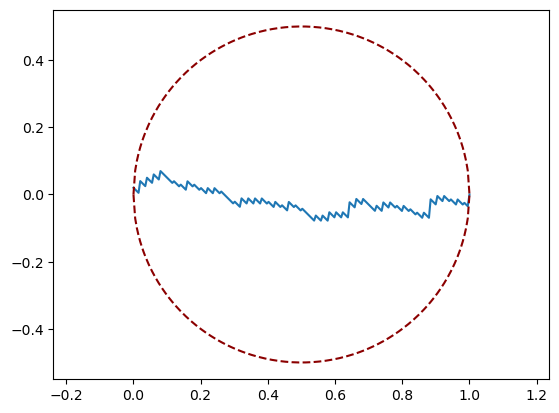

In [12]:
plot_cdf(cs[0])

# Spatial MNIST

In [23]:
model_generators = [
    lambda: SurVAE(
        [
            [BijectiveLayer(100, [64] * 5), OrthonormalLayer(100)]
            for _ in range(20)
        ],
    ),
    lambda: SurVAE(
        [
            [BijectiveLayer(100, [64] * 5), OrthonormalLayer(100)]
            for _ in range(10)
        ] + [
            SortingLayer(),
        ] + [
            [BijectiveLayer(100, [64] * 5), OrthonormalLayer(100)]
            for _ in range(9)
        ],
    ),
]


In [32]:
# Train the datasets
models = {}
batch_size = 1_000
test_size = 10_000
epochs = 5000
log_count = epochs // 10

# Iterate over datasets and create heatm aps
for i, model_generator in enumerate(model_generators):
    model = model_generator()
    print(f"[{i + 1}/{len(model_generators)}] ", end="")

    results = model.train(
        get_spatial_mnist, batch_size=batch_size, test_size=test_size,
        epochs=epochs, lr=0.001, log_count=log_count
    )

    models[i] = (model, results)

[1/2] Starting training... done in 838.25 seconds
[2/2] Starting training... done in 809.62 seconds


In [33]:
model_names = ['NF', 'NF + sorting']

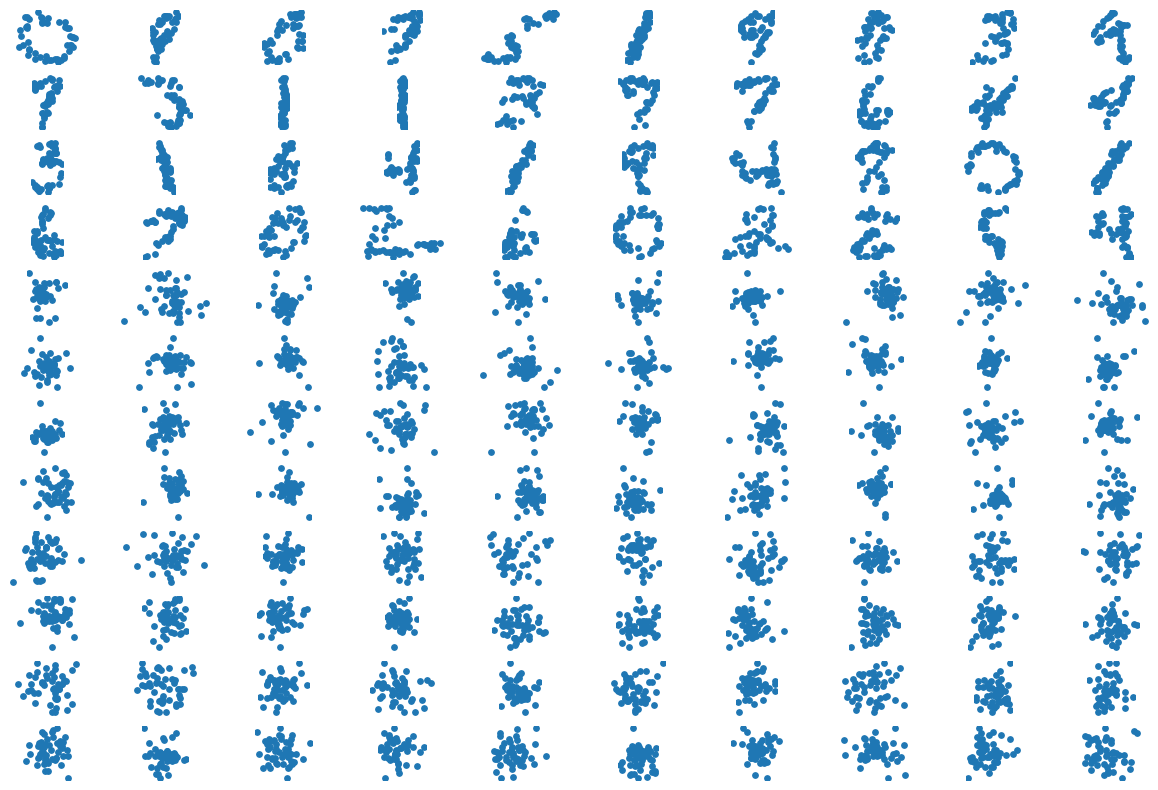

In [34]:
rows = 4 * (1 + len(model_generators))
columns = 10
smnist = get_spatial_mnist(rows * columns)

# Plot the first k*l images with sampled points in a 2D grid
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 10))

for i in range(rows):
    for j in range(columns):
        if i // 4 == 0:
            sample = smnist[i * columns + j]
        elif i // 4 == 1:
            sample = models[0][0].sample(1)[0]
        elif i // 4 == 2:
            sample = models[1][0].sample(1)[0]
        else:
            raise Exception("Should not have happened!")

        ax = axes[i, j]
        points = sample.cpu().numpy().reshape(50, 2)

        ax.scatter(points[:, 0], -points[:, 1], s=15, label='Sampled Points')

        ax.axis('off')
        ax.set_aspect('equal')

plt.show()

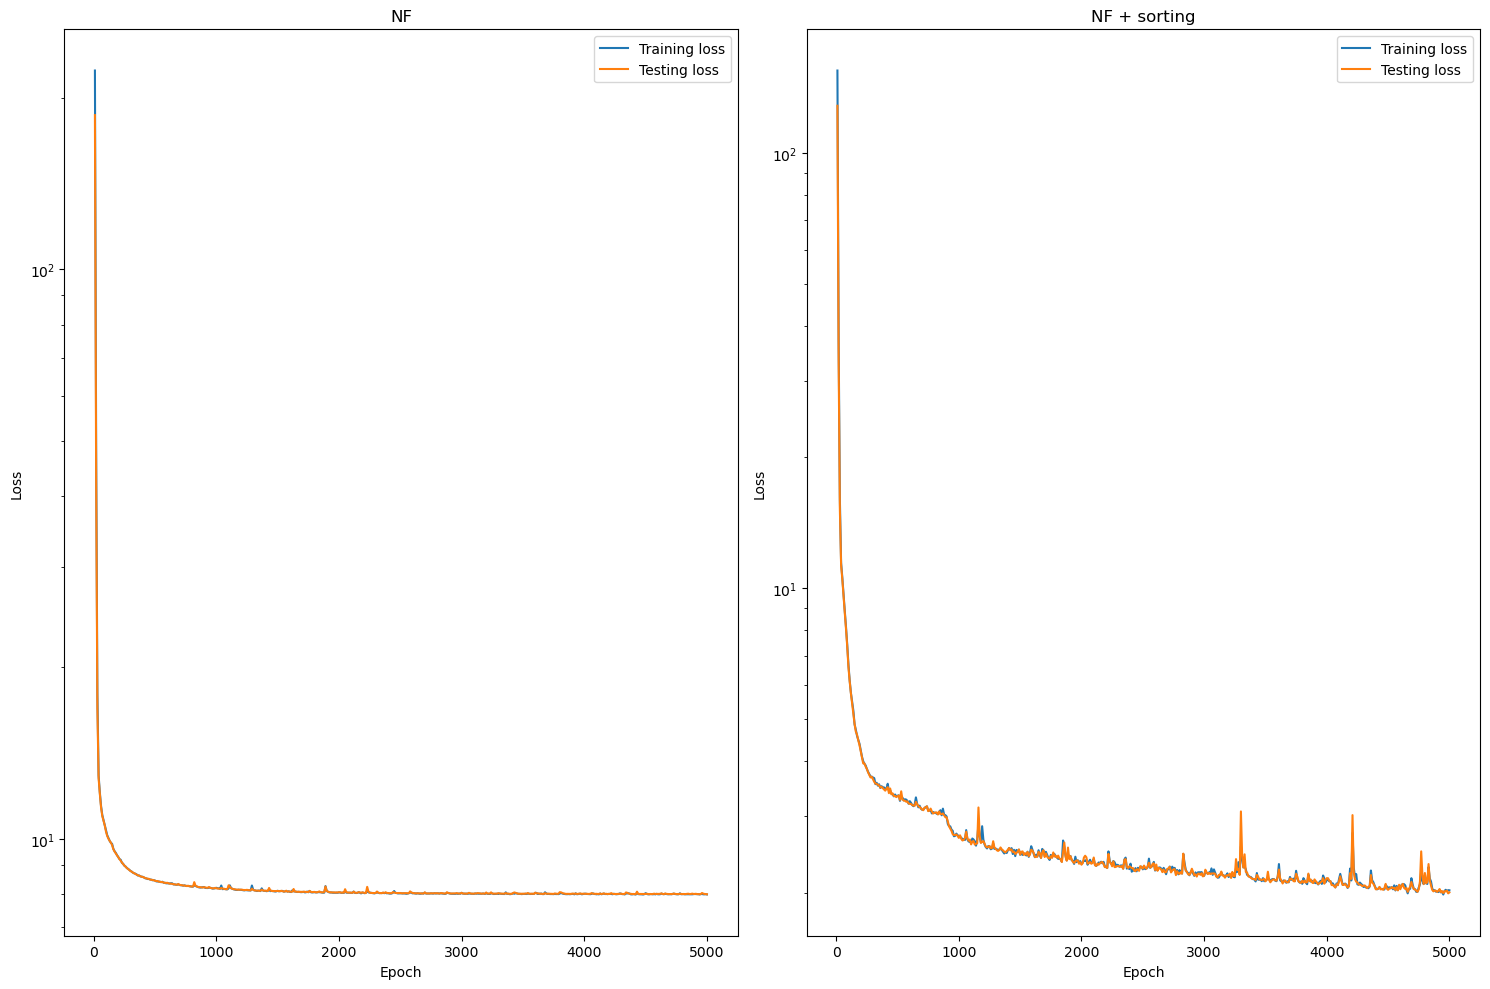

In [35]:
# Create subplots (+1 for the raw data)
fig, axs = plt.subplots(1, len(model_names), figsize=(15, 10))

# Iterate over datasets and create heatmaps for losses
for i, model_name in enumerate(model_names):
    training_loss = [l for _, l, _ in models[i][1].values()]
    testing_loss = [l for _, _, l in models[i][1].values()]
    epochs = list(models[i][1].keys())

    axs[i].plot(epochs, training_loss, label='Training loss')
    axs[i].plot(epochs, testing_loss, label='Testing loss')
    axs[i].set_title(f'{model_name}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].legend()
    axs[i].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()
